In [20]:
%load_ext autoreload
%autoreload 2
from final_project.models import run_model
from final_project.models import save_model_pkl
from final_project.models import load_model
from final_project.models import plot_frequencies
from final_project import builder
from final_project.loader import get_df
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# master_df = get_df(year="2018")
master_df = get_df(all_files=True)
master_df = master_df[master_df['Origin'] == 'BOS']
# master_df = master_df.sample(n=100000, random_state=150)
# builder.runEDA(master_df)
master_df = builder.columnManager(master_df)
master_df = builder.encodeFrame(master_df)
master_df = master_df[["date_sin","date_cos","ArrDel15","month_sin","month_cos","DistanceGroup","WeatherDelay","NASDelay","SecurityDelay"]]

# samples: 512522
train:
 - Number of features:  8
 - Number of samples:  205008
[166163  38845]


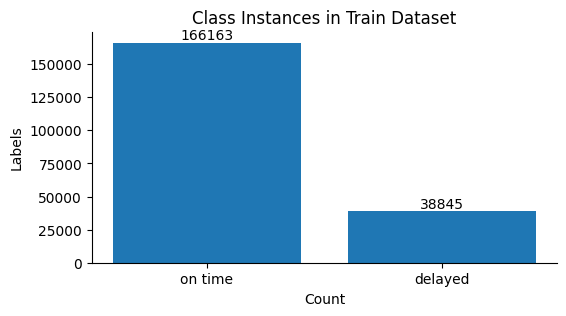


test:
 - Number of features:  8
 - Number of samples:  153757
[124895  28862]


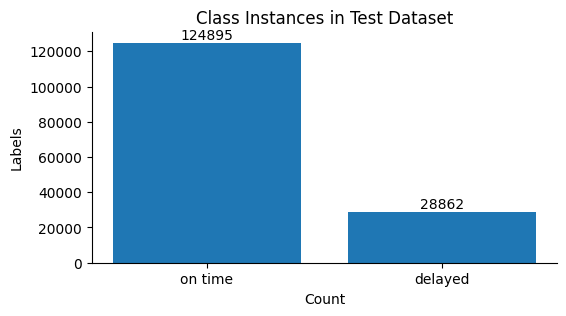


validation:
 - Number of features:  8
 - Number of samples:  153757
[124928  28829]


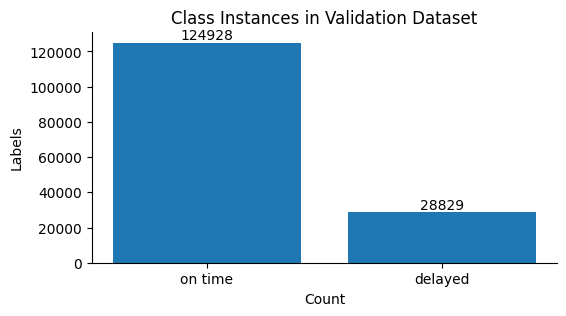

In [22]:
'''
process data for training, split into test/train/validation
'''
X = master_df.drop(columns=["ArrDel15"])
y = master_df[["ArrDel15"]]
y = y.ArrDel15.ravel() # flatten
print("# samples:", y.shape[0])

# split into train and test/validation (which is then split in next line)
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y,
                                                    test_size=0.6,
                                                    random_state=150)

# create validation and test sets each 15% of total data
X_test, X_validation, y_test, y_validation = train_test_split(X_test_val, y_test_val,
                                                    test_size=0.5,
                                                    random_state=150)
data = {"train": (X_train,y_train), "test":(X_test,y_test), "validation": (X_validation,y_validation)}

# number of classes, number of instances in each class
for each in data.keys():
    print(f"{each}:")
    print(" - Number of features: ", len(data[each][0].columns))
    print(" - Number of samples: ", len(data[each][0]))
    unique, counts = np.unique(data[each][1], return_counts=True)
    plot_frequencies(each, (unique, counts))
    print()

In [23]:
# create train numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_validation = X_validation.to_numpy()

# convert to tensors
X_train, y_train, X_test, y_test, X_validation, y_validation = map(
    torch.tensor, (X_train, y_train, X_test, y_test, X_validation, y_validation)
)

In [24]:
# create dataset and dataloader
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
valid_ds = TensorDataset(X_validation, y_validation)
num_features=X_train.shape[1] 

using:  cpu


100%|██████████| 50/50 [05:09<00:00,  6.19s/it]

best loss:  0.2527455985546112
+---------------------------+---------+
| Hyperparameter            |   Value |
+===========================+=========+
| Best batch size:          |   64    |
+---------------------------+---------+
| Best epoch:               |   50    |
+---------------------------+---------+
| Best learning rate:       |    0.01 |
+---------------------------+---------+
| Best num nodes:           |    4    |
+---------------------------+---------+
| Best num layers:          |    2    |
+---------------------------+---------+
| Best momentum:            |    0    |
+---------------------------+---------+
| Best weight decay:        |    0    |
+---------------------------+---------+
| Best dropout probability: |    0    |
+---------------------------+---------+


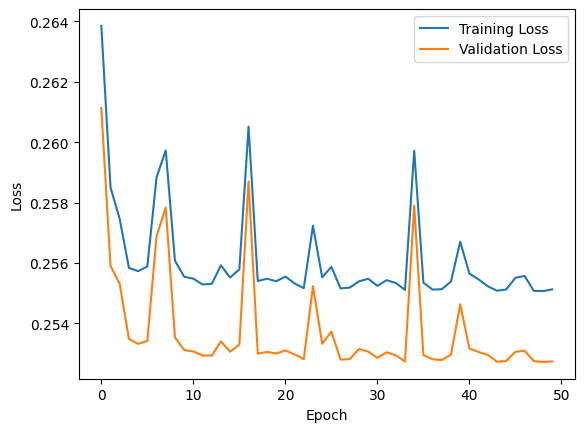

Evaluating **train** dataset:
using:  cpu


100%|██████████| 3204/3204 [00:02<00:00, 1584.57it/s]


Mean Accuracy: 92.535
Mean per-class accuracy:
  on time: 100.000%
  delayed: 60.605%
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    166163
         1.0       1.00      0.61      0.75     38845

    accuracy                           0.93    205008
   macro avg       0.96      0.80      0.86    205008
weighted avg       0.93      0.93      0.92    205008

[[166163      0]
 [ 15303  23542]]

Evaluating **test** dataset:
using:  cpu


100%|██████████| 2403/2403 [00:01<00:00, 1686.32it/s]


Mean Accuracy: 92.649
Mean per-class accuracy:
  on time: 100.000%
  delayed: 60.841%
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    124895
         1.0       1.00      0.61      0.76     28862

    accuracy                           0.93    153757
   macro avg       0.96      0.80      0.86    153757
weighted avg       0.93      0.93      0.92    153757

[[124895      0]
 [ 11302  17560]]

Evaluating **validation** dataset:
using:  cpu


100%|██████████| 2403/2403 [00:01<00:00, 1552.33it/s]


Mean Accuracy: 92.646
Mean per-class accuracy:
  on time: 100.000%
  delayed: 60.776%
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    124928
         1.0       1.00      0.61      0.76     28829

    accuracy                           0.93    153757
   macro avg       0.96      0.80      0.86    153757
weighted avg       0.93      0.93      0.92    153757

[[124928      0]
 [ 11308  17521]]



In [25]:
params = {"bs":(64,),
        "epoch":(50,),
        "learning_rate":(.01,),
        "momentum":(0,),
        "weight_decay":(0,),
        "activation_fn": nn.ReLU,
        "dropout_prob": (0,),
        "num_layers": (2,),
        "num_nodes": (4,)}
best_model_params = run_model(param_dict=params, 
                  train_ds=train_ds, 
                  test_ds=test_ds, 
                  valid_ds=valid_ds,
                  num_features=num_features
                  )

In [26]:
save_model_pkl(best_model_params)

In [27]:
model = load_model("../models/1_2_state_dict.pkl")

In [28]:
model.predict(train_ds)

using:  cpu


100%|██████████| 3204/3204 [00:03<00:00, 1048.16it/s]


(tensor([0, 0, 0,  ..., 1, 1, 1], dtype=torch.int32),
 tensor([0.0997, 0.1058, 0.1210,  ..., 0.7144, 0.7144, 0.7144]),
 tensor([0, 0, 0,  ..., 1, 1, 1], dtype=torch.int32))